# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from utils.detectConstantSegments import detectConstantSegments
from utils.getOperationsStart import getOperationsStart
from utils.computeSlotsAverage import computeSlotsAverage
from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load some data

   

In [2]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
currentSlots = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + currentSlots


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


### Plot the data

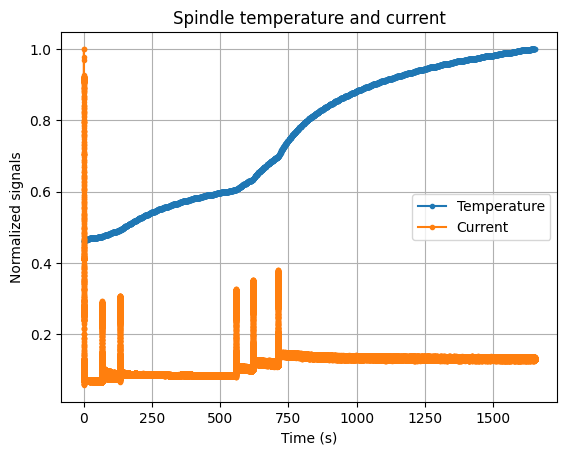

In [3]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

### Plot the data averaged by slots

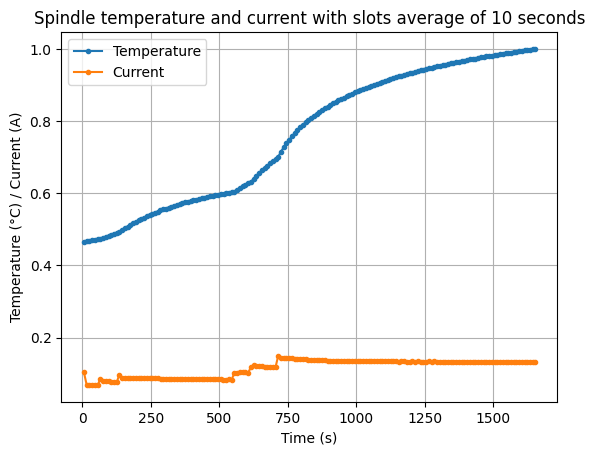

In [4]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Current (A)")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

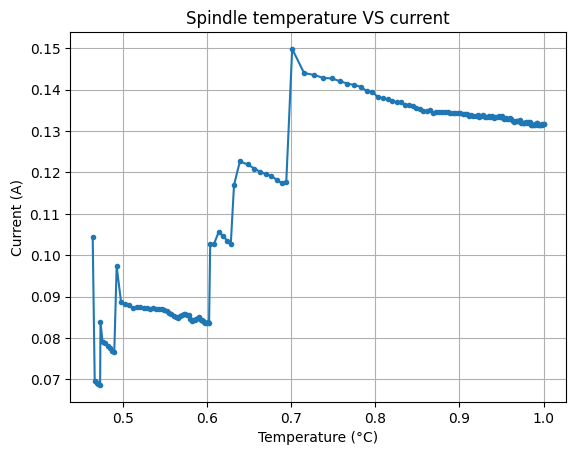

In [5]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Test `getTemperatureCorrectionData` on various samples

We want to plot the current VS temperature plot for multiple samples.

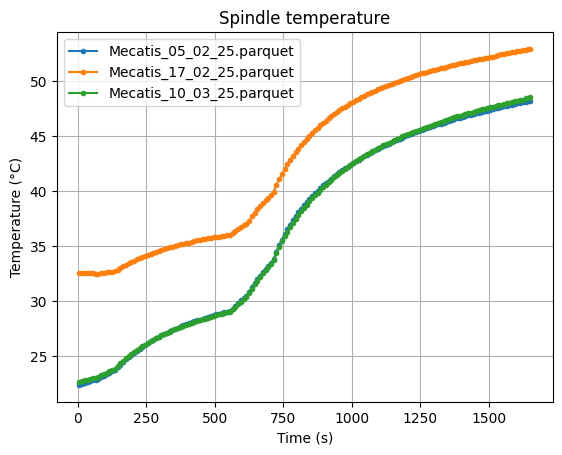

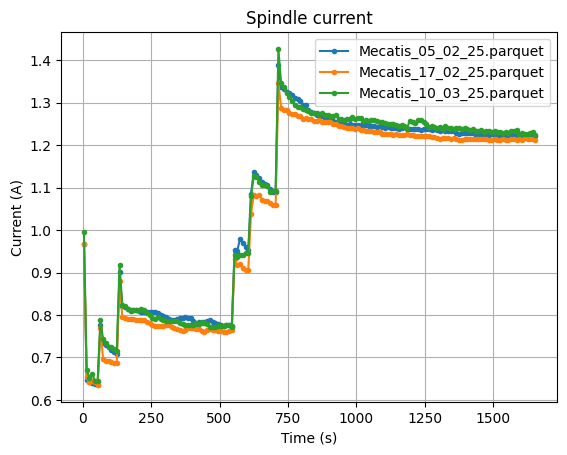

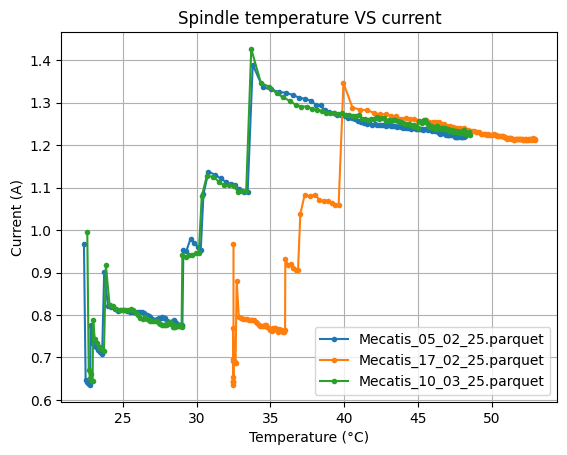

In [28]:
dataPath: Path = "../../data/normalized-2025_04_08/"

samples: list[Path] = ["Mecatis_05_02_25.parquet", "Mecatis_17_02_25.parquet", "Mecatis_10_03_25.parquet"] 

rawData = []
for sample in samples:
    path = os.path.join(dataPath, sample)
    currentData = pd.read_parquet(path)
    rawData.append(getTemperatureCorrectionData(currentData))

showTempCorrectionPlots(rawData, samples)

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [7]:


def errorFun(x: float, data: pd.Series, reference: pd.Series) -> float:
    error = ((data - x - reference)**2).sum()/len(data) # mean square error (MSE)
    return error

def findTemperatureOffset(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(errorFun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse

### Test the function on some data


In [8]:
offset1, error1 = findTemperatureOffset(rawData[1]["temperature"], rawData[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(rawData[2]["temperature"], rawData[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  Mecatis_17_02_25.parquet
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  Mecatis_10_03_25.parquet
Offset:  0.04 °C
RMSE:  0.14 °C


### Plot the corrected data

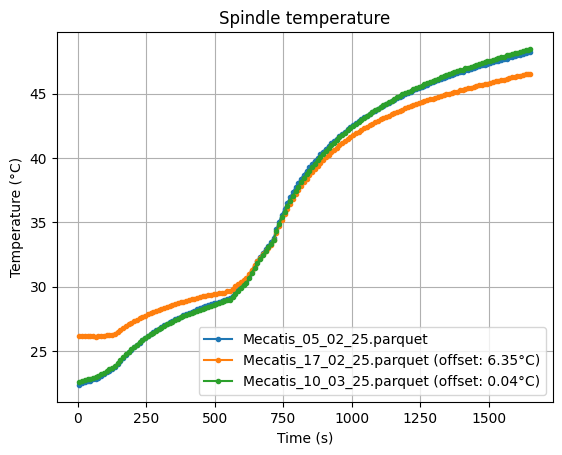

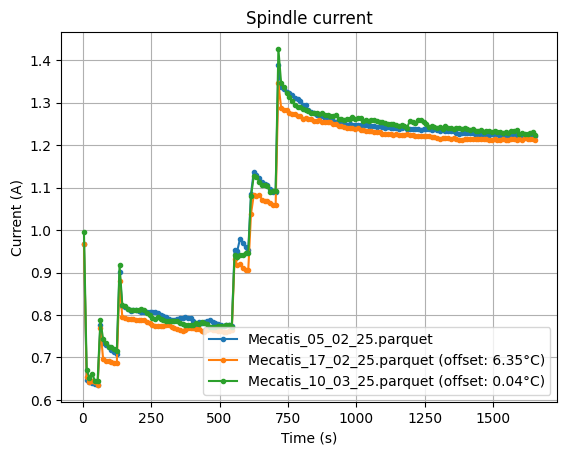

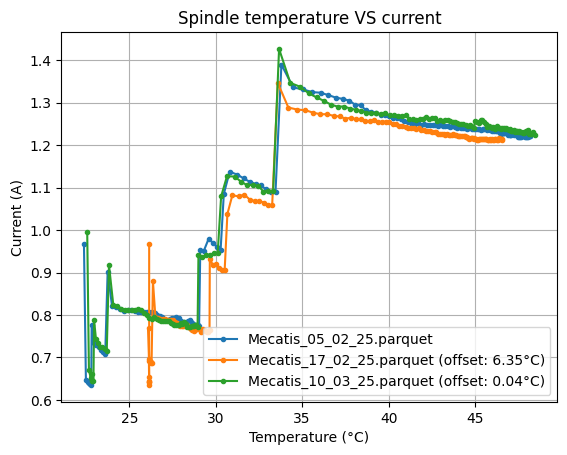

In [9]:
rawData[1]["temperature"] = rawData[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

rawData[2]["temperature"] = rawData[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCorrectionPlots(rawData, samples)

## Check if segments are the same in all samples

In [10]:

dataPath: Path = "../../data/normalized-2025_04_08/"

def getSampleSegmentIndices(samplePath: Path) -> list:
    """
    Get the sample segment indices.

    Parameters
    ----------
    samplePath (str): The path to the sample.

    Returns
    -------
    list: Indices of the sample segments.
    """
    data = pd.read_parquet(samplePath)
    time = data["timeSeconds"]
    command = data["stSigSpindleVelocity"]
    return detectConstantSegments(time, command)

indices1 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_05_02_25.parquet"))
print("Indices 1: ", indices1)
indices2 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_17_02_25.parquet"))
print("Indices 2: ", indices2)
indices3 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_10_03_25.parquet"))
print("Indices 3: ", indices3)


Indices 1:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
Indices 2:  [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]
Indices 3:  [(892, 84083), (84958, 165521), (166396, 694796), (695672, 772690), (773566, 889276), (890151, 2065449)]


Remarks:
- different samples have different segment indices
- samples contains different numcer of points

## Split spindle current into segments
We want to split all the spindle current into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

First, load a sample and put useful signals into some variables.

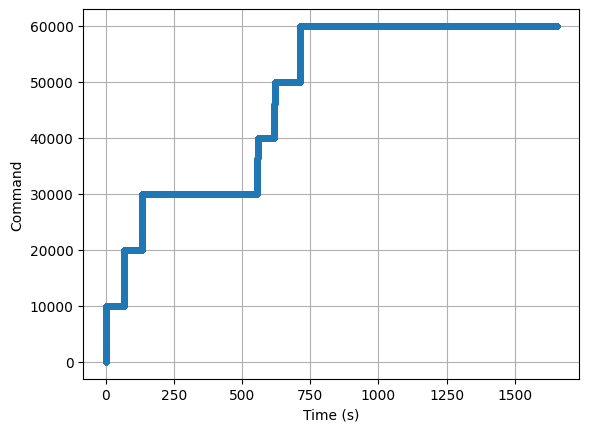

Operation indices:  [0, 81141, 162587, 691869, 769765, 886354]
Segment indices:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]


In [11]:


dataPath: Path = "../../data/normalized-2025_04_08/"
samplePath = os.path.join(dataPath, "Mecatis_05_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]

plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Command")
plt.grid()
plt.show()


operationsIndices = getOperationsStart(rawData["stSigOperation"])

print("Operation indices: ", operationsIndices)

segmentIndices = detectConstantSegments(time, command)
print("Segment indices: ", segmentIndices)

data = getTemperatureCorrectionData(rawData, timeSlot=None)


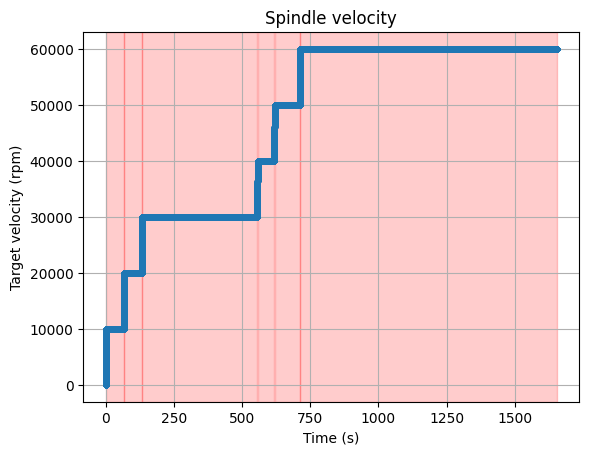

In [12]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

### Plot original spindle current

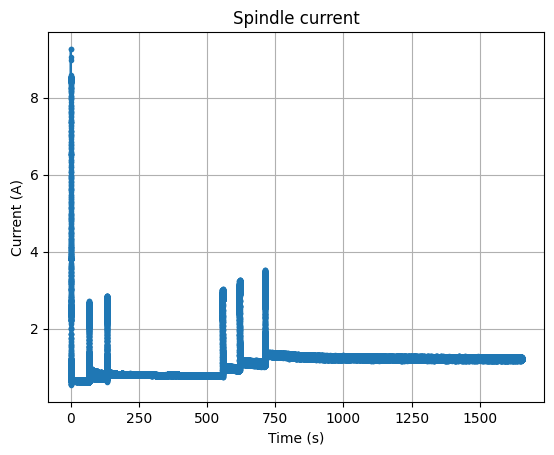

In [13]:
plt.figure()
plt.plot(time, data["current"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("Spindle current")
plt.grid()
plt.show()

### Define functions

In [14]:
def splitSignal(data: pd.DataFrame, indices: list) -> list[pd.DataFrame]:
    """
    Split the data into segments.

    Parameters
    ----------
    signal (pd.DataFrame): The data, which can have any number of columns.
    indices (list): The indices of the segments.

    Returns
    -------
    list: The segments of the signal.
    """
    segments = []
    for segment in indices:
        segments.append(data.iloc[segment[0]:segment[1] + 1])
    return segments 

In [15]:
def splitSignalByOperation(data: pd.DataFrame, indices: list[int]) -> list[pd.DataFrame]:
    """
    Split the data into segments.

    Parameters
    ----------
    signal (pd.DataFrame): The data, which can have any number of columns.
    indices (list[int]): The the start indices of the segments.

    Returns
    -------
    list: The segments of the signal.
    """
    segments = []
    for i in range(len(indices) - 1):
        start = indices[i]
        end = indices[i + 1] - 1

        print("start: ", start)
        print("end: ", end)
        segment = data.iloc[start:end, :]
        segments.append(segment)
    # add the last segment
    start = indices[-1]
    end = len(data)
    segment = data.iloc[start:end, :]
    segments.append(segment)
    return segments

In [16]:
def plotSegments(segments: list[pd.DataFrame], xSignal: str = "timeSeconds", ySignals: list[str] = ["current"],
                 nbPoints: int = None, title = "Spindle current", xlabel: str = "Time (s)", ylabel: str = "Current (A)",
                 legend: list[str] = [] ) -> None:
    """
    Plot the segments of the signal. You can plot multiple signals in the same plot.
    The segments are plotted in a 2x3 grid.

    Parameters
    ----------
    segments (list[pd.DataFrame]): The segments of the signal. Each signal must only have 2 columns.
    xSignal (str): The name of the x signal.
    ySignals (str): The name of the y signals.
    nbPoints (int): The number of points to plot. If None, all points are plotted.
    title (str): The title of the plot.
    xlabel (str): The label of the x-axis.
    ylabel (str)]: The label of the y-axis.

    Returns
    -------
    None
    """
  

    nbSegments = len(segments)
    if nbSegments != 6:
        print("Warning: the number of segments is not 6. The plot may be incorrect.")

    nbColumns = 2
    nbRows = 3

    plt.figure()
    fig, axs = plt.subplots(nbRows, nbColumns, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(title)

    for i in range(len(segmentIndices)):
        x = segments[i].loc[:, xSignal]
        for j in range(len(ySignals)):
          
            ySignal = ySignals[j]
            y = segments[i].loc[:, ySignal]

            colIndex = i % nbColumns
            rowIndex = i // nbColumns

            axs[rowIndex, colIndex].plot(x[:nbPoints], y[:nbPoints], "o-", markersize=3)
        axs[rowIndex, colIndex].set_xlabel(xlabel)
        pointsToPlot = len(x)
        if nbPoints != None:
            pointsToPlot = min(nbPoints, len(x))
        axs[rowIndex, colIndex].set_ylabel(ylabel)
        axs[rowIndex, colIndex].set_title("Segment " + str(i+1) + " (" + str(pointsToPlot) + " points)")
        if len(legend) > 0:
            axs[rowIndex, colIndex].legend(legend)
        axs[rowIndex, colIndex].grid()

    plt.show()

### Test plotting raw segments

<Figure size 640x480 with 0 Axes>

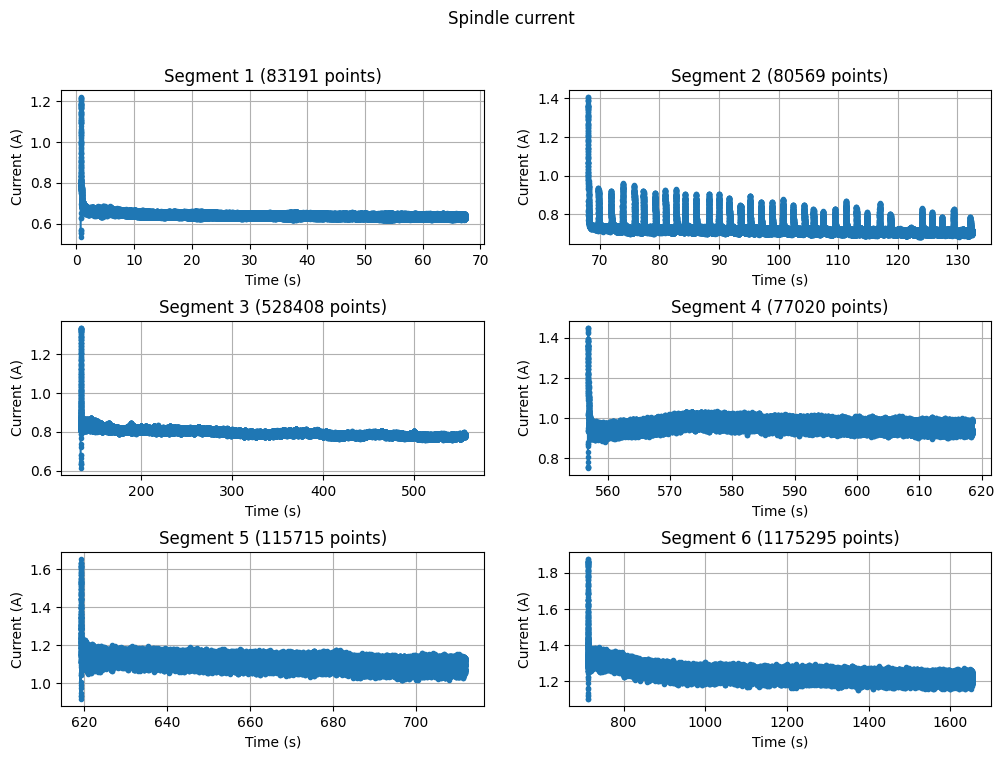

<Figure size 640x480 with 0 Axes>

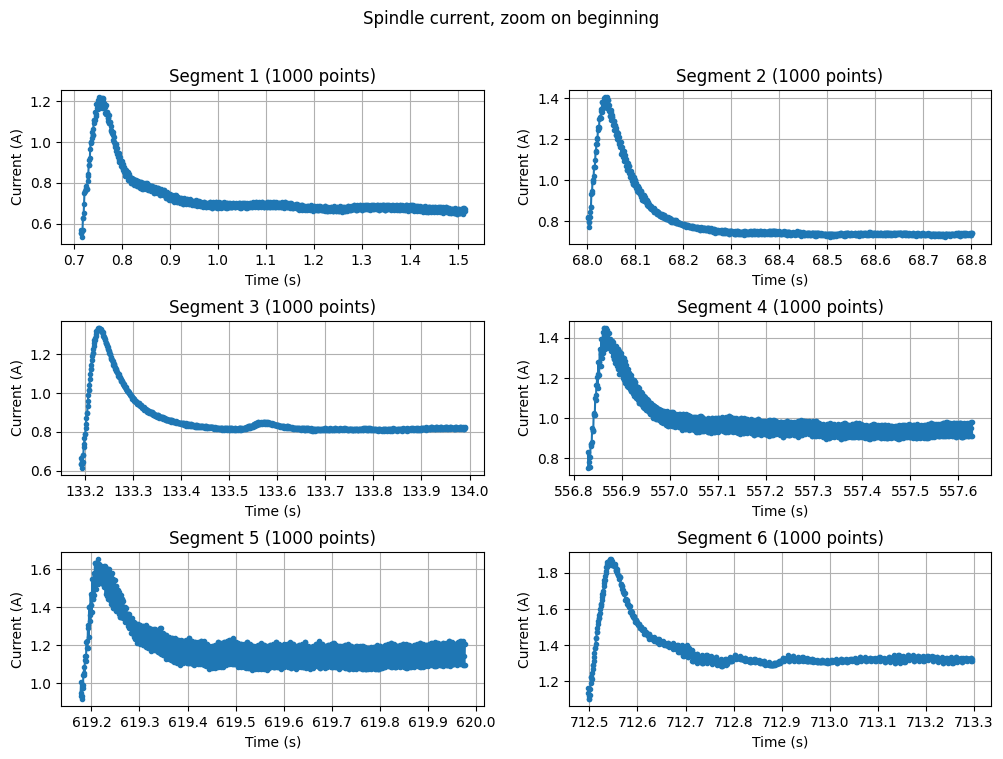

In [17]:
segments = splitSignal(data, segmentIndices)
plotSegments(segments)

# zoom in
plotSegments(segments, nbPoints=1000, title="Spindle current, zoom on beginning")

### Remove points at the beggining of segments

We want to remove the beginning of each segment in order to be in the stable state.

Frequency:  1250.0 Hz
Number of points to remove:  625


<Figure size 640x480 with 0 Axes>

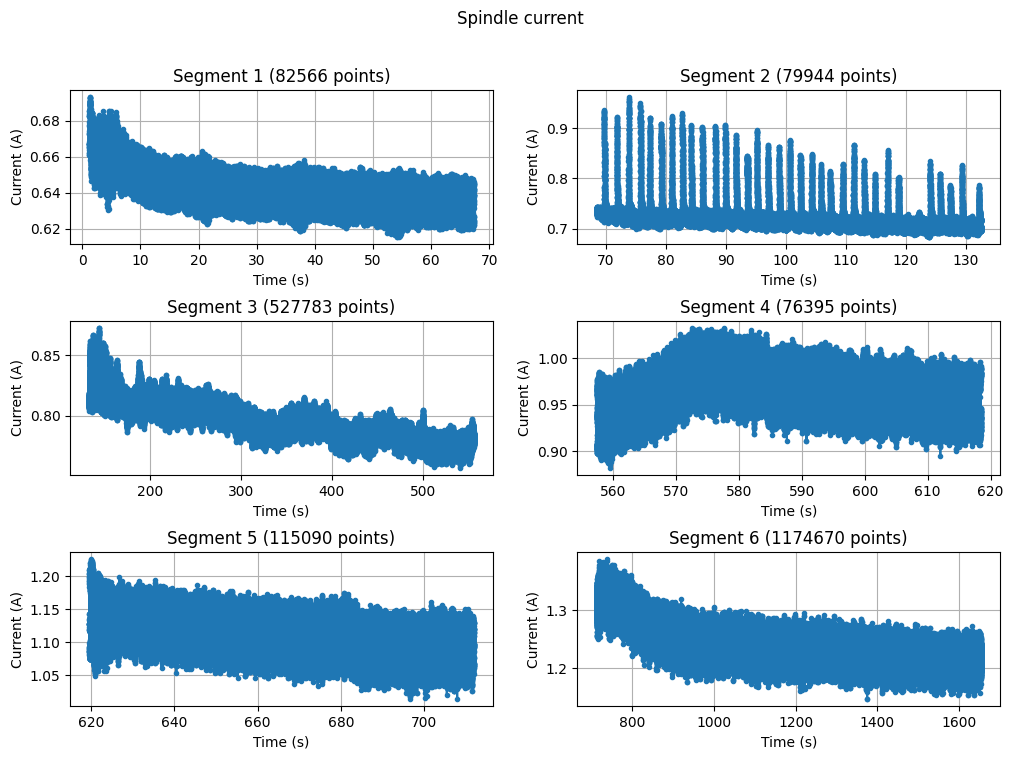

In [18]:
def removeSignalsBeginning(segments: list[pd.DataFrame], timeToRemove: float = 0.5, debug: bool = False) -> list[pd.DataFrame]:
    """
    Remove the first timeToRemove seconds of the signal. Allows to only consider the steady state of the signal.
    """

    frequency = 1 / (data.iloc[1, 0] - data.iloc[0,0]) # Hz
    if debug:
        print("Frequency: ", frequency, "Hz")

    nbPointsToRemove = int(timeToRemove * frequency) # number of points to remove
    if debug:
        print("Number of points to remove: ", nbPointsToRemove)

    cutSegments = []

    for i in range(len(segments)):
        # remove the first nbPointsToRemove points
        cutSegments.append(segments[i].iloc[nbPointsToRemove:, :])
    return cutSegments


cutSegments = removeSignalsBeginning(segments, timeToRemove=0.5, debug=True)
# plot the segments
plotSegments(cutSegments)


### Compute average by slots to reduce nb of points

<Figure size 640x480 with 0 Axes>

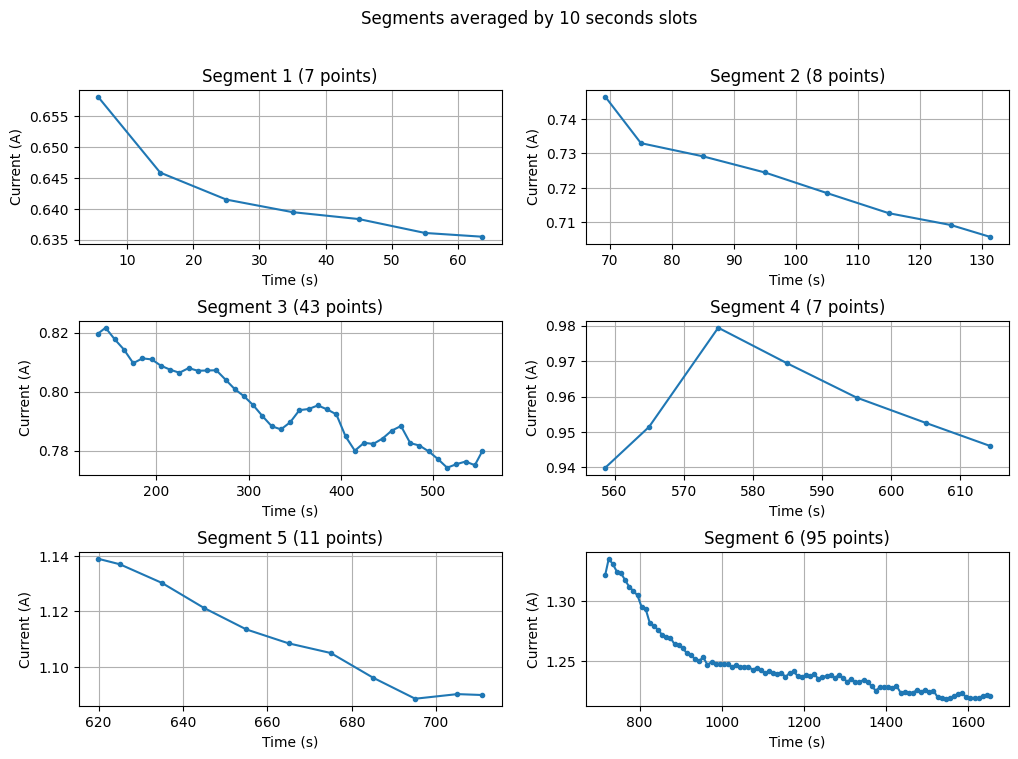

In [30]:
dt = 10 # seconds


averagedSegments = []

for i in range(len(cutSegments)):
    averagedSegments.append(computeSlotsAverage(cutSegments[i], dt))


# plot the segments
plotSegments(averagedSegments, title="Segments averaged by " + str(dt) + " seconds slots")

### Plot current versus temperature for each segment

<Figure size 640x480 with 0 Axes>

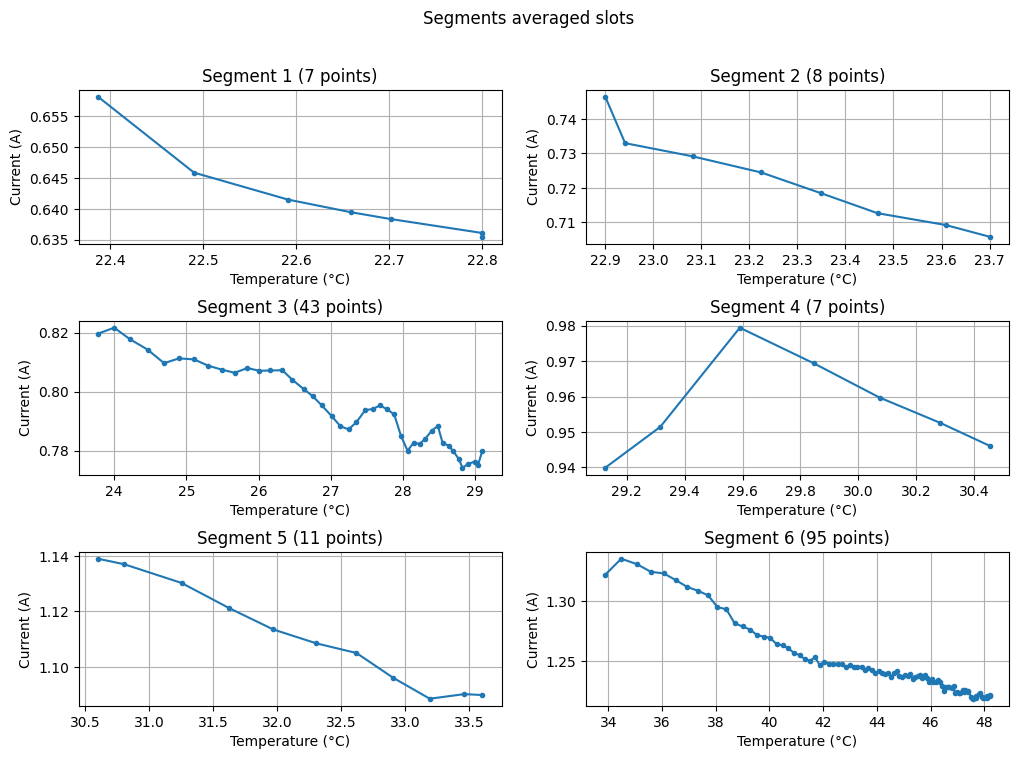

In [20]:
plotSegments(averagedSegments, xSignal= "temperature", ySignals=["current"], ylabel="Current (A)", xlabel="Temperature (°C)", title="Segments averaged slots")

## Compute regressions for each segment    

### Write functions


There is a bug somewhere and I struggled to find it.... In the end I just used the standard numpy functions...

In [21]:

def evalPolyReg(p: list[float], data: pd.DataFrame) -> pd.Series:
    """
    Evaluate a polynomial regression model.
    Parameters
    ----------
    p (list): The parameters of the model.
    data (pd.DataFrame): The data, which should have 2 columns.
    """
    x = data.iloc[:,0] # the first column is the x value
    result = pd.Series([p[0]] * len(x)) # the first parameter is the offset
    for i in range(1, len(p)):
        result += p[i] * x**i
    return result

def errorFun(p: list, data: pd.DataFrame) -> float:
    """
    Function for a polynomial regression model.
    y = p[0] + p[1] * x + p[2] * x^2 + ... + p[n] * x^n
    Parameters
    ----------
    p (list): The parameters of the model.
    data (pd.DataFrame): The data, which should have 2 columns.
    """

    # check if the data has 2 columns
    if len(data.columns) != 2:
        raise ValueError("The data must have 2 columns.")
    
    model = evalPolyReg(p, data)
    y = data.iloc[:,1]
    error = ((y - model)**2).sum()/len(data) # mean square error (MSE)
    return error

def getPolyRegression(data: pd.DataFrame, order = 1) -> list:
    x0 = [0.0] * (order + 1)
    result = minimize(errorFun, x0, args=(data))
    return result.x, np.sqrt(result.fun) # return the weights and the rmse

In [22]:
def getRmse(model: pd.Series, data: pd.Series) -> float:
    """
    Get the root mean square error (RMSE) between the model and the data.
    Parameters
    ----------
    model (pd.Series): The model.
    data (pd.Series): The data.
    """
    rmse = np.sqrt(((model - data)**2).sum()/len(data))
    return rmse

 ### Test the functions

Parameters:  [ 1.75307013 -0.04426569]
RMSE:  0.0032640114781070377
Parameters:  [ 0.00909888  0.10655587 -0.0032602 ]
RMSE:  0.003381250076665538


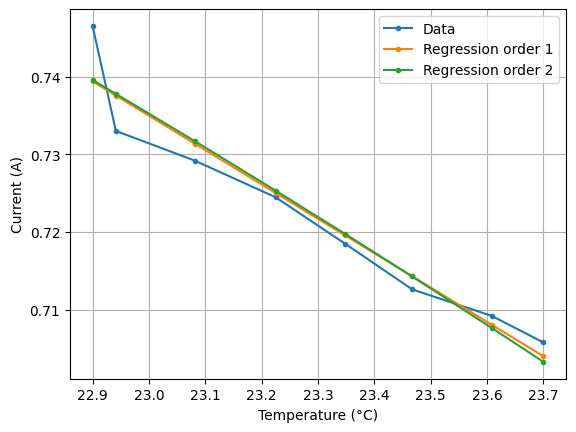

In [23]:
testData = pd.DataFrame()
testData["temperature"] = [1,2,5,6,9,10]
testData["current"] = [0.1,0.4,0.9,1.6,2.5,3.6]

realData = pd.DataFrame()
realData["temperature"] = [22.900000,  
                           22.941293,  
                           23.081673,  
                           23.224596,  
                           23.348171,  
                           23.466880,  
                           23.608718,  
                           23.700000]
  
realData["current"] = [0.746520,
                       0.733001,
                       0.729164,
                       0.724461,
                       0.718472,
                       0.712600,
                       0.709162,
                       0.705753]


# sort data by temperature
realData = realData.sort_values(by="temperature")


data = realData

reg1, err1 = getPolyRegression(data, order=1)
print("Parameters: ", reg1)
print("RMSE: ", err1)

model1 = evalPolyReg(reg1, data)

reg2, err2 = getPolyRegression(data, order=2)
print("Parameters: ", reg2)
print("RMSE: ", err2)

model2 = evalPolyReg(reg2, data)

plt.figure()
plt.plot(data["temperature"], data["current"], "o-", markersize=3)
plt.plot(data["temperature"], model1, "o-", markersize=3)
plt.plot(data["temperature"], model2, "o-", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.legend(["Data", "Regression order 1", "Regression order 2"])
plt.grid()
plt.show()

### Compute regressions on real data

Errors:  0     1.269305
1     6.615018
2     7.029418
3    10.663664
4     3.431879
5     3.948430
dtype: float64


<Figure size 640x480 with 0 Axes>

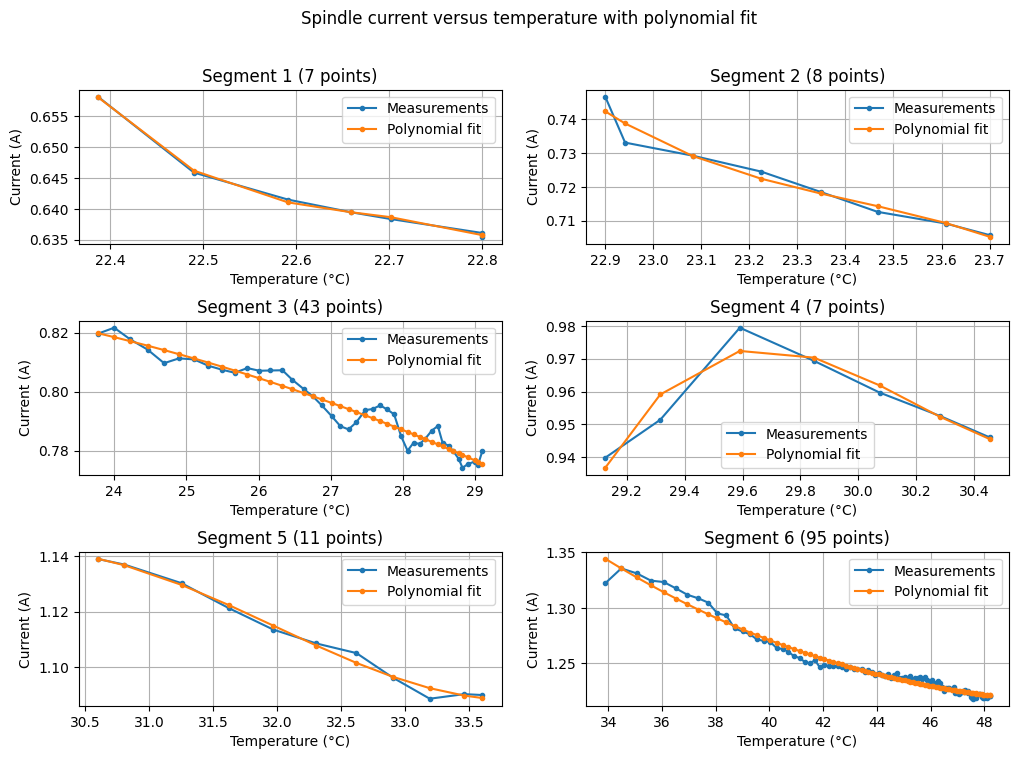

In [36]:
def getPolyFits(segments: list[pd.DataFrame], order: int = 1) -> list[np.poly1d]:
    """
    Get the polynomial fits for each segment.
    Parameters
    ----------
    segments (list[pd.DataFrame]): The segments of the signal.
    order (int): The order of the polynomial fit.
    """
    models = []
    for segment in segments:
        model = np.poly1d(np.polyfit(segment["temperature"], segment["current"], order))
        models.append(model)
    return models

def evalModels(segments: list[pd.DataFrame], models: list[np.poly1d]) -> list[pd.DataFrame]:
    """
    Evaluate the polynomial fits for each segment.
    Parameters
    ----------
    segments (list[pd.DataFrame]): The segments of the signal.
    models (list[np.poly1d]): The polynomial fits for each segment.
    """
    for i in range(len(segments)):
        segments[i] = segments[i].copy()  # Ensure it's a copy
        segments[i].loc[:, "polyFit"] = models[i](segments[i].loc[:, "temperature"])
    return segments


def getErrors(segments: list[pd.DataFrame]) -> list[float]:
    """
    Compute rmse between measurement and polynomial regression for each segment.
    """
    errors = []
    for segment in segments:
        error = getRmse(segment["polyFit"], segment["current"])
        errors.append(error)
    return errors

def getRelativeErrors(segments: list[pd.DataFrame]) -> pd.Series:
    """
    Compute the relative errors in **percents** for each segment. The absolute RMSE is divided by the range of the signal.
    """
    relativeErrors = []
    for segment in segments:
        maxValue = segment["current"].max()
        min = segment["current"].min()
        diff = maxValue - min
        error = getRmse(segment["polyFit"], segment["current"])
        relativeErrors.append(error / diff * 100) # in percent
    
    return pd.Series(relativeErrors)

models = getPolyFits(averagedSegments, order=3)
segments = evalModels(averagedSegments, models)
errors = getRelativeErrors(segments)
print("Errors: ", errors)

   
plotSegments(segments, xSignal= "temperature", ySignals=["current", "polyFit"],
             ylabel="Current (A)", xlabel="Temperature (°C)",
             title="Spindle current versus temperature with polynomial fit",
             legend=["Measurements", "Polynomial fit"])


### Final temperature correction function

We consider the variation of the current depending on the temperature as a bias. In order to remove it, we subtract the regression data from the current data.

In [25]:
def temperatureCorrection(data: pd.DataFrame, segmentIndices: list[tuple], order: int = 3, debug: bool = False) -> pd.Series:
    """
    Apply temperature correction to the data.
    Parameters
    ----------
    data (pd.DataFrame): The data to correct. Should contain the columns "timeSeconds", "temperature" and "current".
    segmentIndices (list): The indices of the start and end of each segment.
    order (int): The order of the polynomial fit.
    debug (bool): If True, print debug information.

    Returns
    -------
    pd.Series: The corrected spindle current.
    """
    nbSegments = len(segmentIndices)
    segments = splitSignal(data, segmentIndices)
    # remove beginning of the signals
    cutSegments = removeSignalsBeginning(segments, debug = debug)
    averagedSegments = []
    for i in range(len(cutSegments)):
        averagedSegments.append(computeSlotsAverage(cutSegments[i]))

    # get the polynomial fits
    models = getPolyFits(averagedSegments, order = order)
    segmentsWithFit = evalModels(averagedSegments, models)
    errors = getRelativeErrors(segmentsWithFit)
    print("Relative error in percents for each segment: ")
    print(errors.round(0))

    # we want to apply the temperature correction to all points
    # redefine segment indices
    correctionIndices = []
    firstSegment = [0, segmentIndices[0][1]]
    correctionIndices.append(firstSegment)
    for i in range(1, len(segmentIndices)):
        start = segmentIndices[i-1][1] + 1
        end = segmentIndices[i][1]
        correctionIndices.append([start, end])
    if debug: 
        print("Correction indices: ", correctionIndices)

    correctionSegments = splitSignal(data, correctionIndices)
    regressions = evalModels(correctionSegments, models)

    # subtract the polynomial fit from the current
    correctedCurrents = []
    totalLength = 0
    for i in range(len(correctionSegments)):
        originalCurrent = correctionSegments[i]["current"]
        regression = regressions[i]["polyFit"]
        # find expected constant current: first point of the averaged segment's regression
        initialCurrent = segmentsWithFit[i].loc[0, "polyFit"]
        if debug:
            print("Initial current: ", initialCurrent)
        correctedCurrents.append(originalCurrent - (regression - initialCurrent))
        totalLength += len(correctedCurrents[i])

   # concatenate the corrected current
    correctedCurrent = pd.concat(correctedCurrents, ignore_index=True)
    print("Corrected current dimensions: ", correctedCurrent.shape)

    return correctedCurrent

## Test the whole temperature correction

In [26]:
import time as timeLib

dataPath: Path = "../../data/normalized-2025_04_08/"

samplePath = os.path.join(dataPath, "Mecatis_17_02_25.parquet")

rawData = pd.read_parquet(samplePath)
time = rawData["timeSeconds"]
command = rawData["stSigSpindleVelocity"]
startTime = timeLib.time()
segmentIndices = detectConstantSegments(time, command)
endTime = timeLib.time()
print("Time to find constant segments: ", endTime - startTime)
data = getTemperatureCorrectionData(rawData, timeSlot=None)

Time to find constant segments:  6.948064804077148


Frequency:  1250.0 Hz
Number of points to remove:  625
Relative error in percents for each segment: 
0    31.0
1     4.0
2     6.0
3     9.0
4     8.0
5     3.0
dtype: float64
Correction indices:  [[0, 84072], [84073, 165512], [165513, 694795], [694796, 772677], [772678, 889265], [889266, 2065435]]
Initial current:  0.6463176203251306
Initial current:  0.7128980493434938
Initial current:  0.7943817104031723
Initial current:  0.9165324561154193
Initial current:  1.0807890846402302
Initial current:  1.2799105640496542
Corrected current dimensions:  (2065436,)


/var/folders/yw/_xsq4q0n0bd5yqsbz7rwv67h0000gp/T/ipykernel_56839/2473138398.py:11: RankWarning: Polyfit may be poorly conditioned
  model = np.poly1d(np.polyfit(segment["temperature"], segment["current"], order))


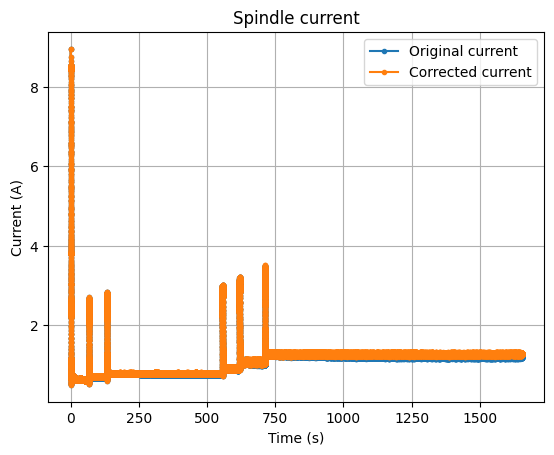

In [37]:
correctedCurrent = temperatureCorrection(data, segmentIndices, debug=True)

# plot the original and corrected current
plt.figure()
plt.plot(data["timeSeconds"], data["current"], "o-", markersize=3)
plt.plot(data["timeSeconds"], correctedCurrent, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.legend(["Original current", "Corrected current"])
plt.title("Spindle current")
plt.grid()

# plt.xlim([554, 560])
# plt.ylim([0,4])
plt.show()